In [1]:
# 📚 استيراد المكتبات الأساسية
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ⚙️ تحديد الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# 🔧 فئة مجموعة البيانات للتصنيف - معدلة لقراءة المجلدات الفرعية
class FabricClassificationDataset(Dataset):
    def __init__(self, defect_dir, nodefect_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        
        # تحميل الصور المعيبة (من مجلد مباشر)
        if os.path.exists(defect_dir):
            for img_name in os.listdir(defect_dir):
                if img_name.endswith('.png') and '_mask' not in img_name:
                    self.images.append(os.path.join(defect_dir, img_name))
                    self.labels.append(1)  # 1 للصور المعيبة
        else:
            print(f"Warning: Defect directory {defect_dir} not found")
                
        # تحميل الصور السليمة من جميع المجلدات الفرعية
        if os.path.exists(nodefect_dir):
            for root, dirs, files in os.walk(nodefect_dir):
                for img_name in files:
                    if img_name.endswith('.png') and '_mask' not in img_name:
                        self.images.append(os.path.join(root, img_name))
                        self.labels.append(0)  # 0 للصور السليمة
        else:
            print(f"Warning: Non-defect directory {nodefect_dir} not found")
        
        print(f"Loaded {len(self.images)} images - Defective: {sum(self.labels)}, Non-defective: {len(self.labels)-sum(self.labels)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 🔧 فئة مجموعة البيانات مع الأقنعة - معدلة لقراءة المجلدات الفرعية
class FabricSegmentationDataset(Dataset):
    def __init__(self, defect_dir, nodefect_dir, mask_dir, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.images = []
        self.masks = []
        self.labels = []
        
        # تحميل الصور المعيبة وأقنعتها (من مجلد مباشر)
        if os.path.exists(defect_dir):
            for img_name in os.listdir(defect_dir):
                if img_name.endswith('.png') and '_mask' not in img_name:
                    img_path = os.path.join(defect_dir, img_name)
                    
                    # إنشاء اسم القنع المطابق
                    base_name = img_name.replace('.png', '')
                    mask_name = f"{base_name}_mask.png"
                    mask_path = os.path.join(mask_dir, mask_name)
                    
                    if os.path.exists(mask_path):
                        self.images.append(img_path)
                        self.masks.append(mask_path)
                        self.labels.append(1)  # معيب
                    else:
                        print(f"Warning: Mask not found for {img_name}")
        else:
            print(f"Warning: Defect directory {defect_dir} not found")
        
        # تحميل الصور السليمة من جميع المجلدات الفرعية (بدون أقنعة)
        if os.path.exists(nodefect_dir):
            for root, dirs, files in os.walk(nodefect_dir):
                for img_name in files:
                    if img_name.endswith('.png') and '_mask' not in img_name:
                        img_path = os.path.join(root, img_name)
                        self.images.append(img_path)
                        self.masks.append(None)  # لا يوجد قنع للصور السليمة
                        self.labels.append(0)  # سليم
        else:
            print(f"Warning: Non-defect directory {nodefect_dir} not found")
        
        print(f"Loaded {len(self.images)} images - With masks: {len([m for m in self.masks if m is not None])}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        # معالجة الصورة
        if self.transform:
            image = self.transform(image)
        
        # إذا كانت الصورة معيبة، حمّل القنع
        if mask_path is not None and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            if self.target_transform:
                mask = self.target_transform(mask)
            else:
                mask = transforms.ToTensor()(mask)
        else:
            # للصور السليمة، أنشئ قنعاً أسود (لا عيوب)
            if isinstance(image, torch.Tensor):
                mask = torch.zeros((1, image.shape[1], image.shape[2]))
            else:
                mask = torch.zeros((1, 256, 256))
        
        return image, mask, label

In [3]:
# 🎯 تحويلات البيانات
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # تحويلات خاصة بالأقنعة
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    return train_transform, val_transform, mask_transform

# 📊 تحميل وتقسيم بيانات التصنيف
def prepare_classification_data(defect_path, nodefect_path, batch_size=16):
    train_transform, val_transform, _ = get_transforms()
    
    full_dataset = FabricClassificationDataset(defect_path, nodefect_path, transform=train_transform)
    
    # تقسيم البيانات
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # تطبيق تحويلات التحقق على مجموعتي التحقق والاختبار
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Classification Data:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

# 📊 تحميل وتقسيم بيانات Segmentation
def prepare_segmentation_data(defect_path, nodefect_path, mask_path, batch_size=8):
    train_transform, val_transform, mask_transform = get_transforms()
    
    full_dataset = FabricSegmentationDataset(
        defect_path, nodefect_path, mask_path, 
        transform=train_transform, 
        target_transform=mask_transform
    )
    
    # تقسيم البيانات
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # تطبيق تحويلات التحقق
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Segmentation Data:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

In [4]:
# 🧠 نموذج CNN من الصفر للتصنيف
class FabricCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FabricCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 🔄 نموذج Transfer Learning للتصنيف
class FabricTransferLearning(nn.Module):
    def __init__(self, num_classes=2):
        super(FabricTransferLearning, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        
        # تجميد الأوزان في الطبقات الأولى
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # استبدال الطبقة الأخيرة
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [5]:
# 🎯 نموذج U-Net مبسط للكشف عن العيوب
class FabricSegmentationModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FabricSegmentationModel, self).__init__()
        
        # Encoder (Downsampling)
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = self._block(512, 1024)
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._block(128, 64)
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)        # 64 channels
        enc2 = self.enc2(self.pool(enc1))  # 128 channels
        enc3 = self.enc3(self.pool(enc2))  # 256 channels
        enc4 = self.enc4(self.pool(enc3))  # 512 channels
        
        # Bridge
        bridge = self.bridge(self.pool(enc4))  # 1024 channels
        
        # Decoder with skip connections
        dec4 = self.upconv4(bridge)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return torch.sigmoid(self.final(dec1))

In [6]:
# 📈 وظيفة تدريب التصنيف
def train_classification_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, model_name='model'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # مرحلة التدريب
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.cpu())
        
        # مرحلة التحقق
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}')
        
        # حفظ أفضل نموذج
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, f'best_{model_name}.pth')
            print(f'New best model saved with val_acc: {best_val_acc:.4f}')
    
    # تحميل أفضل الأوزان
    model.load_state_dict(best_model_wts)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

# 📈 وظيفة تدريب Segmentation
def train_segmentation_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    model.train()
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f'Segmentation Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # التدريب
        model.train()
        running_loss = 0.0
        
        for images, masks, labels in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # التحقق
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks, labels in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * images.size(0)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        
        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
        
        # حفظ أفضل نموذج
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f'New best segmentation model saved with val_loss: {best_val_loss:.4f}')
    
    return train_losses, val_losses

In [7]:
# 📊 تقييم نماذج التصنيف
def evaluate_classification_model(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # تقرير التصنيف
    print(f"\n{'='*50}")
    print(f"Classification Results for {model_name}")
    print(f"{'='*50}")
    print(classification_report(all_labels, all_preds, target_names=['Non-defective', 'Defective']))
    
    # مصفوفة الارتباك
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-defective', 'Defective'],
                yticklabels=['Non-defective', 'Defective'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    return accuracy

# 🔍 تصور نتائج Segmentation
def visualize_segmentation_results(model, test_loader, num_samples=3):
    model.eval()
    _, val_transform, _ = get_transforms()
    
    with torch.no_grad():
        for i, (images, masks, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            
            # تحويل للعرض
            img_np = images[0].cpu().permute(1, 2, 0).numpy()
            # إعادة تطبيع للعرض
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            
            mask_np = masks[0][0].cpu().numpy()  # قناة واحدة
            pred_np = predictions[0][0].cpu().numpy()
            
            # رسم النتائج
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            axes[0].imshow(img_np)
            axes[0].set_title('Input Image')
            axes[0].axis('off')
            
            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')
            
            axes[2].imshow(pred_np, cmap='gray')
            axes[2].set_title('Predicted Mask')
            axes[2].axis('off')
            
            # عرض التداخل
            axes[3].imshow(img_np)
            axes[3].imshow(pred_np, cmap='jet', alpha=0.5)
            axes[3].set_title('Overlay (Red = Defect)')
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.savefig(f'segmentation_result_{i}.png', dpi=300, bbox_inches='tight')
            plt.show()

# 📈 رسم مقارنة التدريب
def plot_training_comparison(cnn_history, tl_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # دقة التصنيف
    axes[0, 0].plot(cnn_history['train_accuracies'], label='CNN Train')
    axes[0, 0].plot(cnn_history['val_accuracies'], label='CNN Val')
    axes[0, 0].set_title('CNN Classification Accuracy')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    
    axes[0, 1].plot(tl_history['train_accuracies'], label='TL Train')
    axes[0, 1].plot(tl_history['val_accuracies'], label='TL Val')
    axes[0, 1].set_title('Transfer Learning Accuracy')
    axes[0, 1].legend()
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    
    # خسارة التصنيف
    axes[1, 0].plot(cnn_history['train_losses'], label='CNN Train')
    axes[1, 0].plot(cnn_history['val_losses'], label='CNN Val')
    axes[1, 0].set_title('CNN Classification Loss')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    
    axes[1, 1].plot(tl_history['train_losses'], label='TL Train')
    axes[1, 1].plot(tl_history['val_losses'], label='TL Val')
    axes[1, 1].set_title('Transfer Learning Loss')
    axes[1, 1].legend()
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# 🚀 تدريب ومقارنة نماذج التصنيف
def train_and_compare_classification(defect_path, nodefect_path):
    # تحضير البيانات
    print("Preparing classification data...")
    train_loader, val_loader, test_loader = prepare_classification_data(defect_path, nodefect_path)
    
    # 🔥 تدريب نموذج CNN من الصفر
    print("\nTraining CNN from scratch...")
    cnn_model = FabricCNN(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
    
    cnn_history = train_classification_model(
        cnn_model, train_loader, val_loader, criterion, cnn_optimizer, 
        num_epochs=30, model_name='cnn_model'
    )
    
    # 🔄 تدريب نموذج Transfer Learning
    print("\nTraining Transfer Learning Model...")
    tl_model = FabricTransferLearning(num_classes=2).to(device)
    tl_optimizer = optim.Adam(tl_model.parameters(), lr=0.0001, weight_decay=1e-4)
    
    tl_history = train_classification_model(
        tl_model, train_loader, val_loader, criterion, tl_optimizer,
        num_epochs=25, model_name='tl_model'
    )
    
    # 📈 مقارنة النتائج
    print("\nComparing classification models...")
    plot_training_comparison(cnn_history, tl_history)
    
    # 🧪 تقييم النماذج
    print("\nEvaluating CNN Model...")
    cnn_accuracy = evaluate_classification_model(cnn_model, test_loader, "CNN Model")
    
    print("\nEvaluating Transfer Learning Model...")
    tl_accuracy = evaluate_classification_model(tl_model, test_loader, "Transfer Learning Model")
    
    # 🏆 اختيار النموذج الأفضل
    print(f"\n{'='*60}")
    print("FINAL CLASSIFICATION COMPARISON")
    print(f"{'='*60}")
    print(f"CNN Model Accuracy: {cnn_accuracy:.4f}")
    print(f"Transfer Learning Model Accuracy: {tl_accuracy:.4f}")
    
    if cnn_accuracy > tl_accuracy:
        best_model = cnn_model
        best_model_name = "CNN Model"
        best_accuracy = cnn_accuracy
        print("🏆 CNN Model is selected as the best classification model!")
    else:
        best_model = tl_model
        best_model_name = "Transfer Learning Model"
        best_accuracy = tl_accuracy
        print("🏆 Transfer Learning Model is selected as the best classification model!")
    
    # 💾 حفظ النموذج الأفضل
    torch.save(best_model.state_dict(), 'best_classification_model.pth')
    print(f"Best classification model saved as 'best_classification_model.pth'")
    
    return best_model, best_model_name, best_accuracy, test_loader

# 🚀 تدريب نموذج Segmentation
def train_segmentation(defect_path, nodefect_path, mask_path):
    # تحضير البيانات
    print("Preparing segmentation data...")
    train_loader, val_loader, test_loader = prepare_segmentation_data(defect_path, nodefect_path, mask_path)
    
    # 🎯 إنشاء وتدريب نموذج Segmentation
    print("\nTraining Segmentation Model...")
    seg_model = FabricSegmentationModel().to(device)
    seg_criterion = nn.BCELoss()  # Binary Cross Entropy للـ Segmentation
    seg_optimizer = optim.Adam(seg_model.parameters(), lr=0.001)
    
    train_losses, val_losses = train_segmentation_model(
        seg_model, train_loader, val_loader, seg_criterion, seg_optimizer, num_epochs=20
    )
    
    # 📈 رسم خسائر التدريب
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Segmentation Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('segmentation_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 🔍 تصور النتائج
    print("\nVisualizing segmentation results...")
    visualize_segmentation_results(seg_model, test_loader)
    
    return seg_model

In [9]:
# 🔍 دالة للتحقق من هيكل المجلدات وعد الصور
def analyze_dataset_structure(defect_path, nodefect_path, mask_path):
    print("🔍 Analyzing dataset structure...")
    
    # تحليل الصور المعيبة
    defect_images = []
    if os.path.exists(defect_path):
        for img_name in os.listdir(defect_path):
            if img_name.endswith('.png') and '_mask' not in img_name:
                defect_images.append(img_name)
        print(f"📁 Defect folder: {len(defect_images)} images")
    else:
        print(f"❌ Defect folder not found: {defect_path}")
    
    # تحليل الصور السليمة (بما في ذلك المجلدات الفرعية)
    nodefect_images = []
    subfolders = []
    if os.path.exists(nodefect_path):
        for root, dirs, files in os.walk(nodefect_path):
            # حساب المجلدات الفرعية
            if root != nodefect_path:
                subfolders.append(os.path.basename(root))
                
            for img_name in files:
                if img_name.endswith('.png') and '_mask' not in img_name:
                    nodefect_images.append(os.path.join(root, img_name))
        
        print(f"📁 Non-defect folder: {len(nodefect_images)} images in {len(subfolders)} subfolders")
        if subfolders:
            print(f"   Subfolders: {subfolders}")
    else:
        print(f"❌ Non-defect folder not found: {nodefect_path}")
    
    # تحليل الأقنعة
    mask_images = []
    if os.path.exists(mask_path):
        for img_name in os.listdir(mask_path):
            if img_name.endswith('.png'):
                mask_images.append(img_name)
        print(f"📁 Mask folder: {len(mask_images)} images")
    else:
        print(f"❌ Mask folder not found: {mask_path}")
    
    return defect_images, nodefect_images, mask_images, subfolders

# 🚀 تدريب ومقارنة نماذج التصنيف
def train_and_compare_classification(defect_path, nodefect_path):
    # تحضير البيانات
    print("Preparing classification data...")
    train_loader, val_loader, test_loader = prepare_classification_data(defect_path, nodefect_path)
    
    # 🔥 تدريب نموذج CNN من الصفر
    print("\nTraining CNN from scratch...")
    cnn_model = FabricCNN(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
    
    cnn_history = train_classification_model(
        cnn_model, train_loader, val_loader, criterion, cnn_optimizer, 
        num_epochs=30, model_name='cnn_model'
    )
    
    # 🔄 تدريب نموذج Transfer Learning
    print("\nTraining Transfer Learning Model...")
    tl_model = FabricTransferLearning(num_classes=2).to(device)
    tl_optimizer = optim.Adam(tl_model.parameters(), lr=0.0001, weight_decay=1e-4)
    
    tl_history = train_classification_model(
        tl_model, train_loader, val_loader, criterion, tl_optimizer,
        num_epochs=25, model_name='tl_model'
    )
    
    # 📈 مقارنة النتائج
    print("\nComparing classification models...")
    plot_training_comparison(cnn_history, tl_history)
    
    # 🧪 تقييم النماذج
    print("\nEvaluating CNN Model...")
    cnn_accuracy = evaluate_classification_model(cnn_model, test_loader, "CNN Model")
    
    print("\nEvaluating Transfer Learning Model...")
    tl_accuracy = evaluate_classification_model(tl_model, test_loader, "Transfer Learning Model")
    
    # 🏆 اختيار النموذج الأفضل
    print(f"\n{'='*60}")
    print("FINAL CLASSIFICATION COMPARISON")
    print(f"{'='*60}")
    print(f"CNN Model Accuracy: {cnn_accuracy:.4f}")
    print(f"Transfer Learning Model Accuracy: {tl_accuracy:.4f}")
    
    if cnn_accuracy > tl_accuracy:
        best_model = cnn_model
        best_model_name = "CNN Model"
        best_accuracy = cnn_accuracy
        print("🏆 CNN Model is selected as the best classification model!")
    else:
        best_model = tl_model
        best_model_name = "Transfer Learning Model"
        best_accuracy = tl_accuracy
        print("🏆 Transfer Learning Model is selected as the best classification model!")
    
    # 💾 حفظ النموذج الأفضل
    torch.save(best_model.state_dict(), 'best_classification_model.pth')
    print(f"Best classification model saved as 'best_classification_model.pth'")
    
    return best_model, best_model_name, best_accuracy, test_loader

# 🚀 تدريب نموذج Segmentation
def train_segmentation(defect_path, nodefect_path, mask_path):
    # تحضير البيانات
    print("Preparing segmentation data...")
    train_loader, val_loader, test_loader = prepare_segmentation_data(defect_path, nodefect_path, mask_path)
    
    # 🎯 إنشاء وتدريب نموذج Segmentation
    print("\nTraining Segmentation Model...")
    seg_model = FabricSegmentationModel().to(device)
    seg_criterion = nn.BCELoss()  # Binary Cross Entropy للـ Segmentation
    seg_optimizer = optim.Adam(seg_model.parameters(), lr=0.001)
    
    train_losses, val_losses = train_segmentation_model(
        seg_model, train_loader, val_loader, seg_criterion, seg_optimizer, num_epochs=20
    )
    
    # 📈 رسم خسائر التدريب
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Segmentation Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('segmentation_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 🔍 تصور النتائج
    print("\nVisualizing segmentation results...")
    visualize_segmentation_results(seg_model, test_loader)
    
    return seg_model

In [10]:
# 🔍 اختبار صورة فردية للتصنيف
def test_classification_single_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, prediction = torch.max(probabilities, 1)
        
    class_names = ['Non-defective', 'Defective']
    result = class_names[prediction.item()]
    confidence = confidence.item()
    
    # عرض النتيجة
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Classification: {result} (Confidence: {confidence:.4f})')
    plt.axis('off')
    plt.show()
    
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.4f}")
    
    return result, confidence

# 🔍 اختبار صورة فردية للـ Segmentation
def test_segmentation_single_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        prediction = (output > 0.5).float()
    
    # تحويل للعرض
    img_np = image_tensor[0].cpu().permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    pred_np = prediction[0][0].cpu().numpy()
    
    # حساب نسبة العيب
    defect_ratio = np.sum(pred_np > 0.5) / (pred_np.shape[0] * pred_np.shape[1])
    
    # رسم النتائج
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(img_np)
    axes[1].imshow(pred_np, cmap='jet', alpha=0.5)
    axes[1].set_title(f'Segmentation Result (Defect: {defect_ratio:.2%})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Defect Ratio: {defect_ratio:.4f}")
    
    return pred_np, defect_ratio

🔍 Analyzing dataset structure...
📁 Defect folder: 106 images
📁 Non-defect folder: 141 images in 7 subfolders
   Subfolders: ['2306881-210020u', '2306894-210033u', '2311517-195063u', '2311694-1930c7u', '2311694-2040n7u', '2311980-185026u', '2608691-202020u']
📁 Mask folder: 107 images

📊 Final Dataset Summary:
✅ Total defect images: 106
✅ Total non-defect images: 141
✅ Total mask images: 107
✅ Subfolders in non-defect: 7

🎯 TRAINING CLASSIFICATION MODELS
Preparing classification data...
Loaded 247 images - Defective: 106, Non-defective: 141
Classification Data:
  Training samples: 172
  Validation samples: 37
  Test samples: 38

Training CNN from scratch...
Epoch 1/30
--------------------------------------------------
Train Loss: 0.6916, Acc: 0.5930
Val Loss: 0.8276, Acc: 0.5135
New best model saved with val_acc: 0.5135
Epoch 2/30
--------------------------------------------------
Train Loss: 0.7100, Acc: 0.5872
Val Loss: 0.6930, Acc: 0.5135
Epoch 3/30
-----------------------------------

c:\Users\User\.conda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\.conda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
--------------------------------------------------
Train Loss: 0.6672, Acc: 0.6047
Val Loss: 0.7072, Acc: 0.5135
New best model saved with val_acc: 0.5135
Epoch 2/25
--------------------------------------------------
Train Loss: 0.5707, Acc: 0.7093
Val Loss: 0.6856, Acc: 0.6486
New best model saved with val_acc: 0.6486
Epoch 3/25
--------------------------------------------------
Train Loss: 0.4682, Acc: 0.7849
Val Loss: 0.7010, Acc: 0.5946
Epoch 4/25
--------------------------------------------------
Train Loss: 0.3338, Acc: 0.8663
Val Loss: 0.3228, Acc: 0.8919
New best model saved with val_acc: 0.8919
Epoch 5/25
--------------------------------------------------
Train Loss: 0.2242, Acc: 0.9244
Val Loss: 0.2263, Acc: 0.9189
New best model saved with val_acc: 0.9189
Epoch 6/25
--------------------------------------------------
Train Loss: 0.1437, Acc: 0.9535
Val Loss: 0.2165, Acc: 0.9189
Epoch 7/25
--------------------------------------------------
Train Loss: 0.1228, Acc: 0

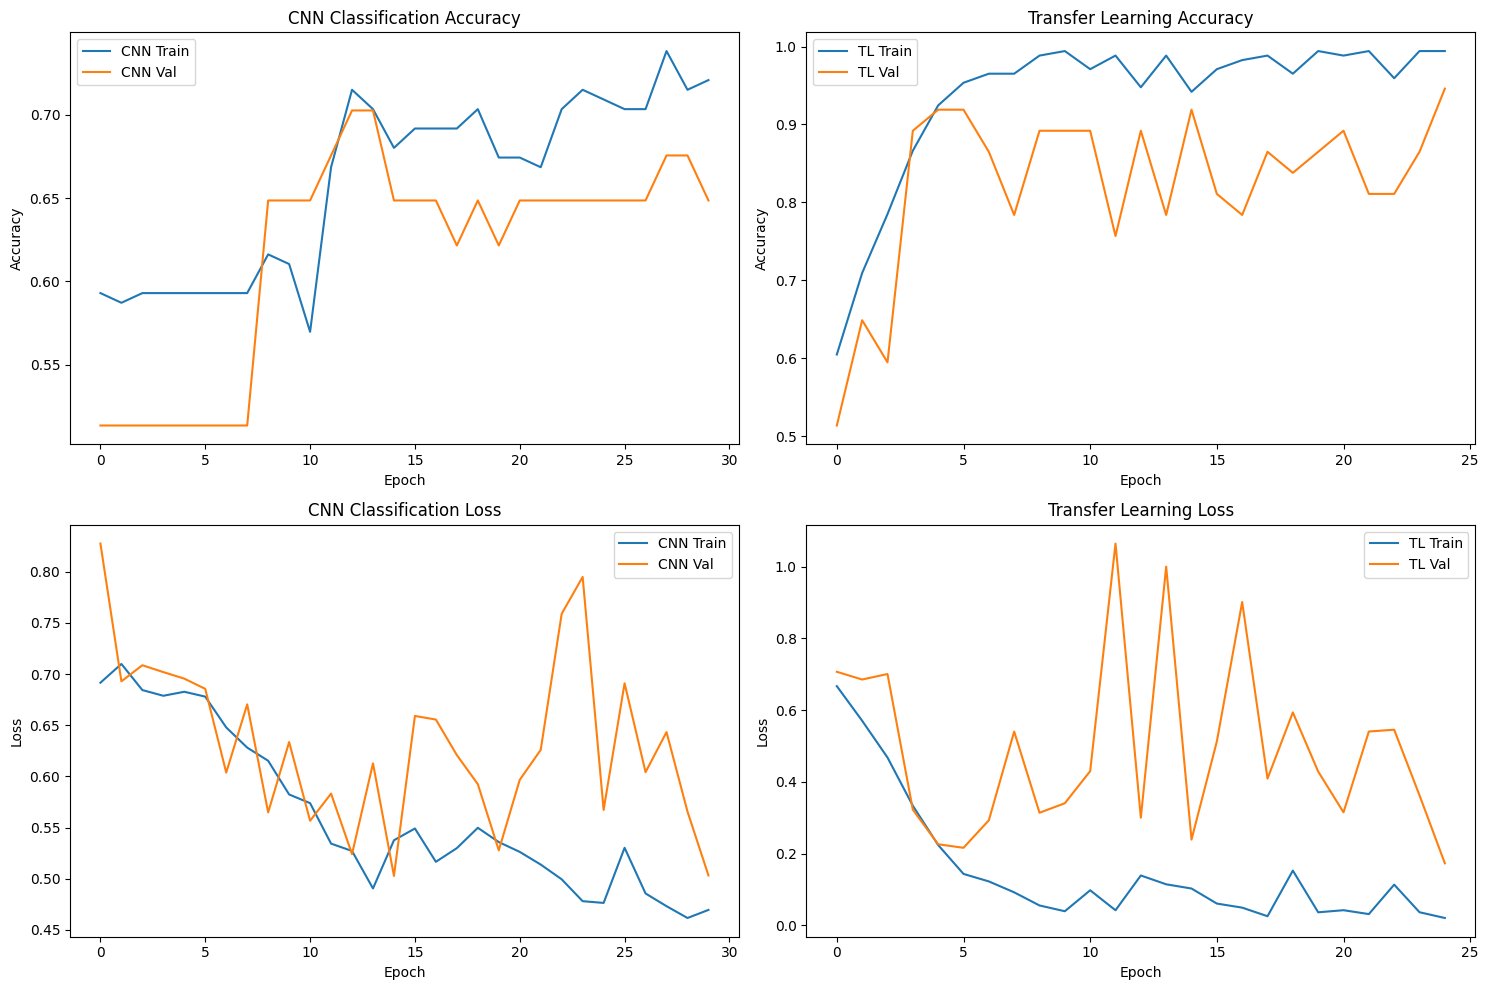


Evaluating CNN Model...

Classification Results for CNN Model
               precision    recall  f1-score   support

Non-defective       0.57      1.00      0.73        20
    Defective       1.00      0.17      0.29        18

     accuracy                           0.61        38
    macro avg       0.79      0.58      0.51        38
 weighted avg       0.77      0.61      0.52        38



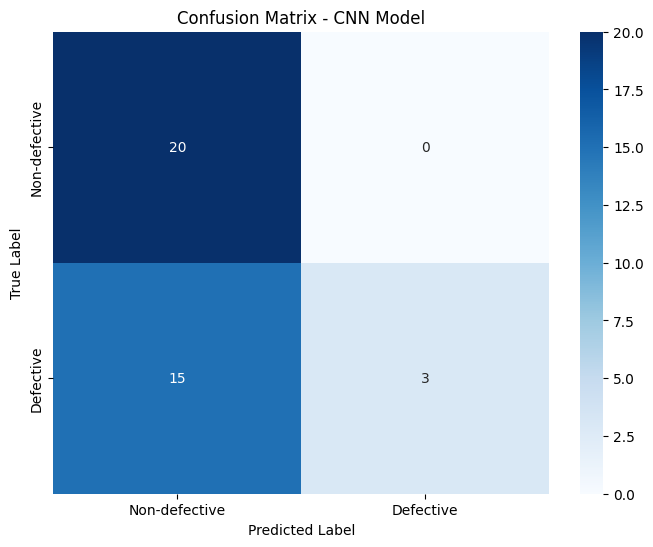

Overall Accuracy: 0.6053

Evaluating Transfer Learning Model...

Classification Results for Transfer Learning Model
               precision    recall  f1-score   support

Non-defective       0.91      1.00      0.95        20
    Defective       1.00      0.89      0.94        18

     accuracy                           0.95        38
    macro avg       0.95      0.94      0.95        38
 weighted avg       0.95      0.95      0.95        38



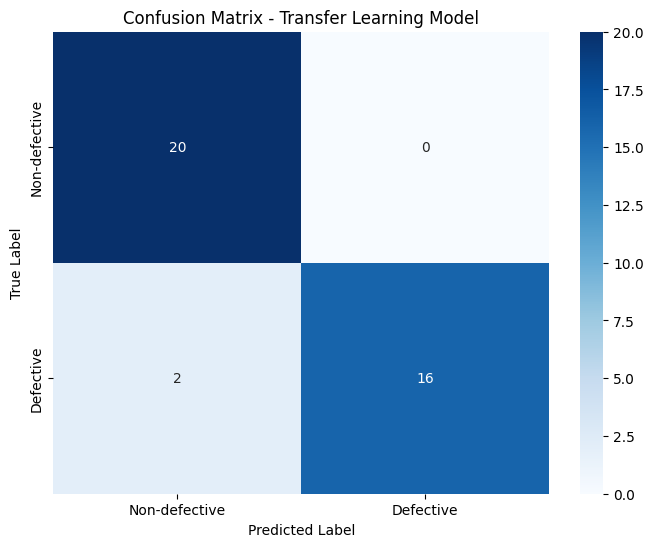

Overall Accuracy: 0.9474

FINAL CLASSIFICATION COMPARISON
CNN Model Accuracy: 0.6053
Transfer Learning Model Accuracy: 0.9474
🏆 Transfer Learning Model is selected as the best classification model!
Best classification model saved as 'best_classification_model.pth'

🎯 TRAINING SEGMENTATION MODEL
Preparing segmentation data...
Loaded 244 images - With masks: 103
Segmentation Data:
  Training samples: 170
  Validation samples: 36
  Test samples: 38

Training Segmentation Model...
Segmentation Epoch 1/20
--------------------------------------------------
Train Loss: 0.3623, Val Loss: 0.2297
New best segmentation model saved with val_loss: 0.2297
Segmentation Epoch 2/20
--------------------------------------------------
Train Loss: 0.1824, Val Loss: 0.1842
New best segmentation model saved with val_loss: 0.1842
Segmentation Epoch 3/20
--------------------------------------------------
Train Loss: 0.1254, Val Loss: 0.1221
New best segmentation model saved with val_loss: 0.1221
Segmentation E

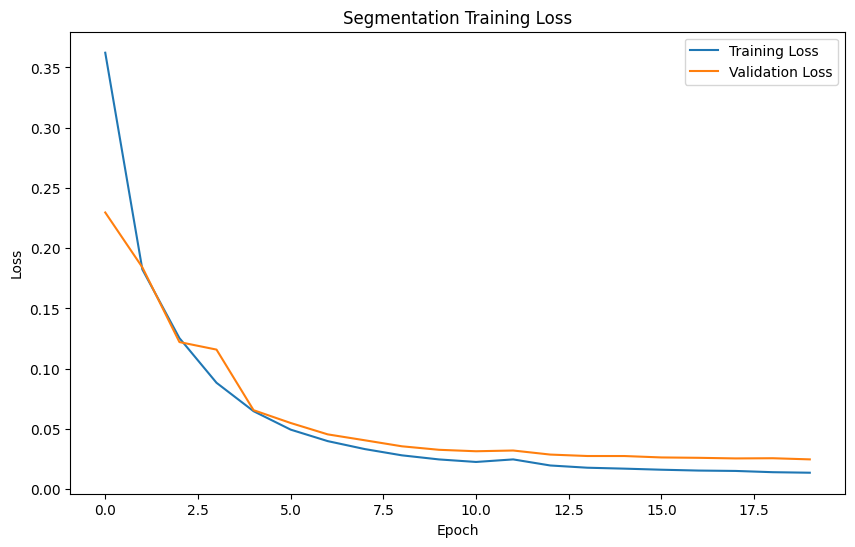


Visualizing segmentation results...


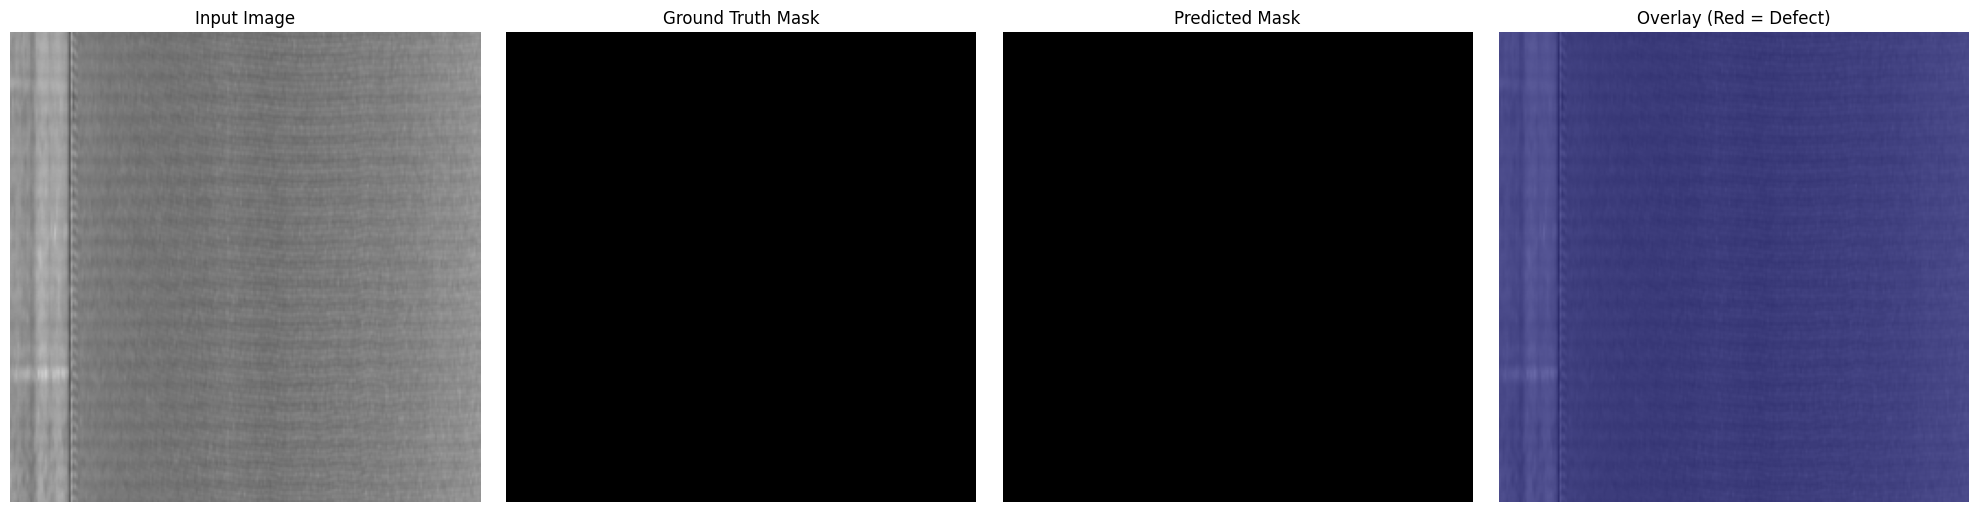

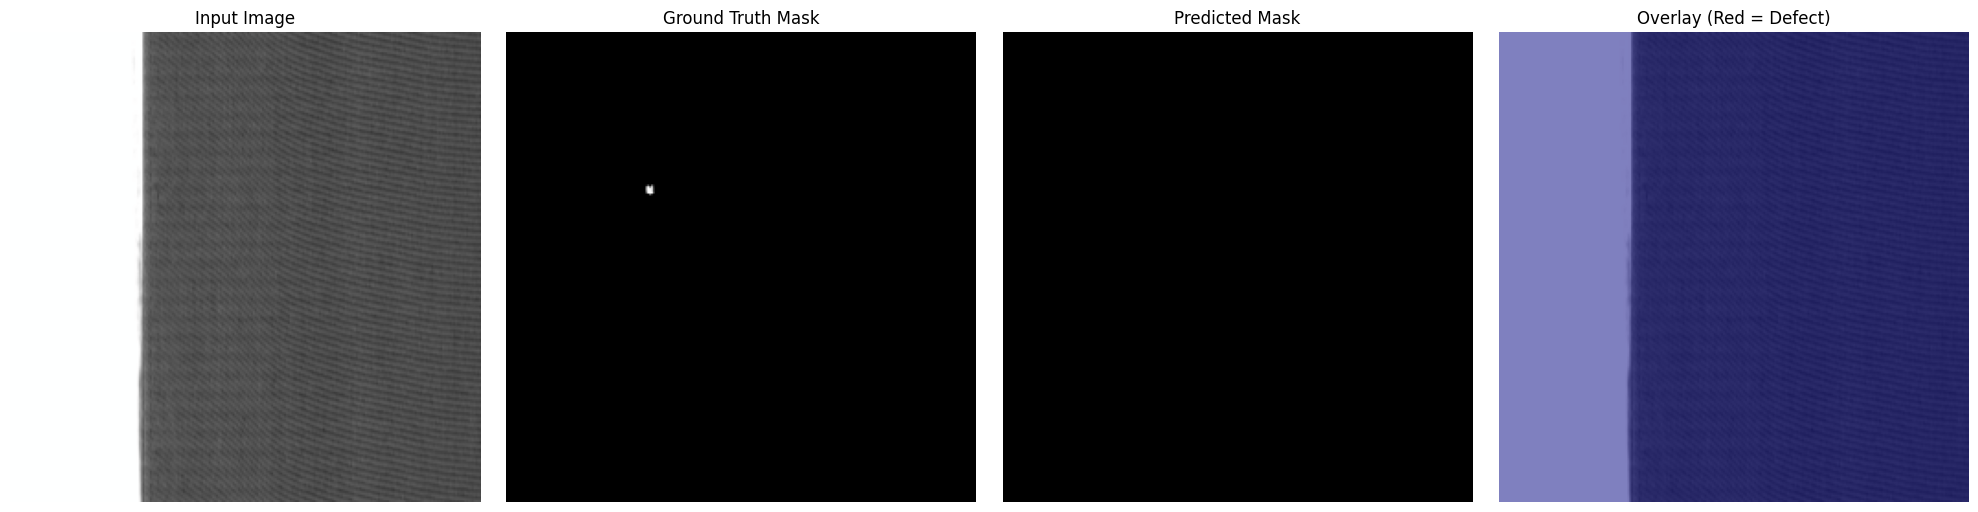

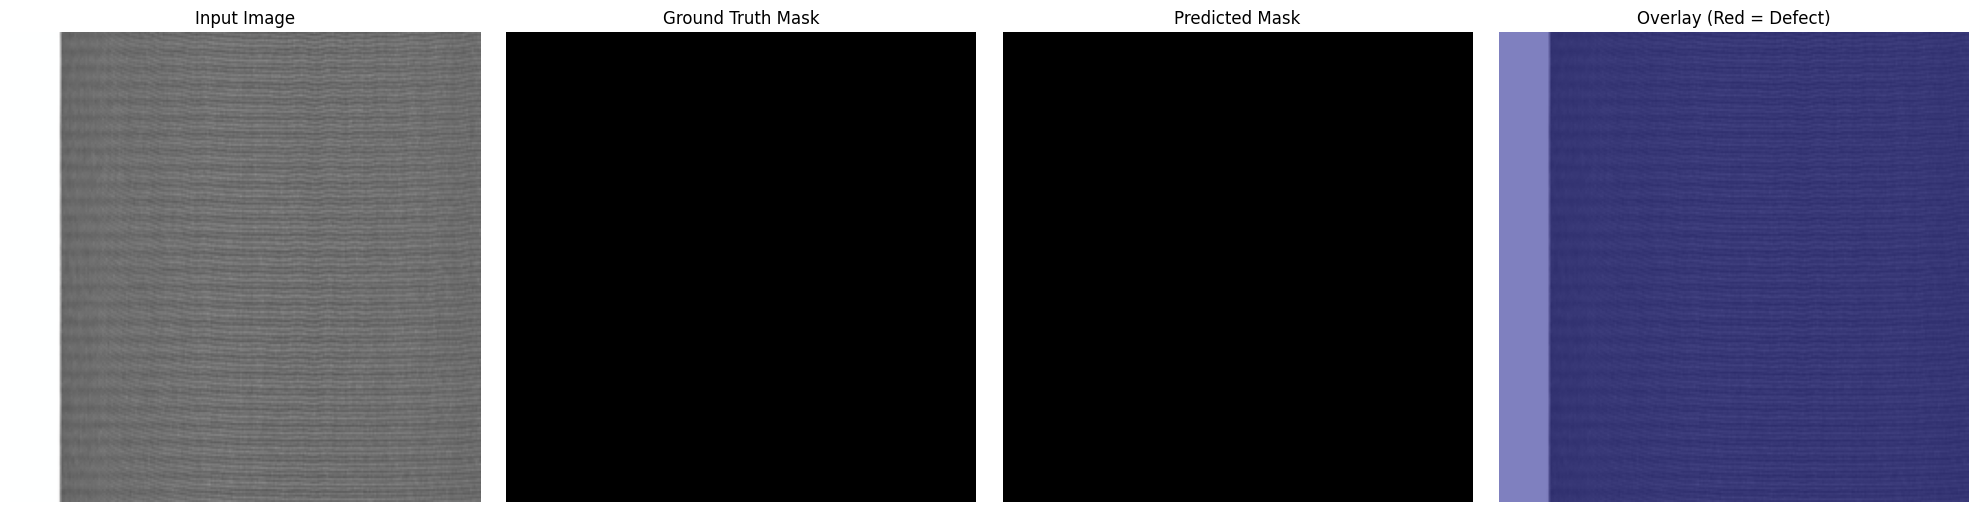


🎯 All training completed!
   Best classification model: Transfer Learning Model with accuracy: 0.9474

🧪 Testing models on sample images...
Loaded 247 images - Defective: 106, Non-defective: 141
❌ Error during execution: name 'random' is not defined


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_22372\2979363442.py", line 68, in <module>
    test_indices = random.sample(range(len(sample_dataset)), min(3, len(sample_dataset)))
NameError: name 'random' is not defined


In [12]:
# 🎯 التنفيذ الرئيسي - معدل للمجلدات الفرعية
def main():
    # ⚠️ ⚠️ ⚠️ المسارات - تأكد من تعديلها ⚠️ ⚠️ ⚠️
    
    # المسارات الأساسية
    DEFECT_PATH = r"C:\Users\User\Desktop\Defect_images"       # مجلد الصور المعيبة (مباشر)
    NODEFECT_PATH = r"C:\Users\User\Desktop\NODefect_images"   # مجلد الصور السليمة (يحتوي على مجلدات فرعية)  
    MASK_PATH = r"C:\Users\User\Desktop\Mask_images"           # مجلد الأقنعة (مباشر)
    
    # تحليل هيكل البيانات أولاً
    defect_imgs, nodefect_imgs, mask_imgs, subfolders = analyze_dataset_structure(DEFECT_PATH, NODEFECT_PATH, MASK_PATH)
    
    # التحقق من وجود بيانات كافية
    if len(defect_imgs) == 0 or len(nodefect_imgs) == 0:
        print("❌ Error: Not enough images found in one or more folders")
        return
    
    if len(mask_imgs) == 0:
        print("⚠️ Warning: No mask images found. Segmentation training will be limited.")
    
    print(f"\n📊 Final Dataset Summary:")
    print(f"✅ Total defect images: {len(defect_imgs)}")
    print(f"✅ Total non-defect images: {len(nodefect_imgs)}") 
    print(f"✅ Total mask images: {len(mask_imgs)}")
    print(f"✅ Subfolders in non-defect: {len(subfolders)}")
    
    # 1. تدريب نماذج التصنيف
    print("\n" + "="*60)
    print("🎯 TRAINING CLASSIFICATION MODELS")
    print("="*60)
    
    best_class_model, model_name, accuracy, test_loader = train_and_compare_classification(DEFECT_PATH, NODEFECT_PATH)
    
    # 2. تدريب نموذج Segmentation (فقط إذا كانت هناك أقنعة)
    if len(mask_imgs) > 0:
        print("\n" + "="*60)
        print("🎯 TRAINING SEGMENTATION MODEL")
        print("="*60)
        
        seg_model = train_segmentation(DEFECT_PATH, NODEFECT_PATH, MASK_PATH)
    else:
        seg_model = None
        print("\n⚠️ Skipping segmentation training - no mask images found")
    
    print(f"\n🎯 All training completed!")
    print(f"   Best classification model: {model_name} with accuracy: {accuracy:.4f}")
    
    return best_class_model, seg_model

if __name__ == "__main__":
    # تدريب جميع النماذج
    try:
        classification_model, segmentation_model = main()
        
        # اختبار النماذج على صور عشوائية
        print("\n🧪 Testing models on sample images...")
        _, val_transform, _ = get_transforms()
        
        # إنشاء dataset للوصول إلى الصور
        sample_dataset = FabricClassificationDataset(
            r"C:\Users\User\Desktop\Defect_images",
            r"C:\Users\User\Desktop\NODefect_images", 
            transform=val_transform
        )
        
        # اختبار بعض الصور العشوائية
        if len(sample_dataset) > 0:
            test_indices = random.sample(range(len(sample_dataset)), min(3, len(sample_dataset)))
            
            for idx in test_indices:
                img_path = sample_dataset.images[idx]
                print(f"\nTesting: {os.path.basename(img_path)}")
                test_classification_single_image(classification_model, img_path, val_transform)
                
                if segmentation_model is not None:
                    test_segmentation_single_image(segmentation_model, img_path, val_transform)
        else:
            print("No images found for testing")
                
    except Exception as e:
        print(f"❌ Error during execution: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy import ndimage
import tkinter as tk
from tkinter import filedialog, messagebox
import sys

# 🔧 إعداد واجهة المستخدم لاختيار الملفات
def setup_file_dialog():
    """إعداد نافذة لاختيار الملفات"""
    root = tk.Tk()
    root.withdraw()  # إخفاء النافذة الرئيسية
    return root

# 🔧 تحميل النماذج المدربة
def load_models():
    # نموذج التصنيف
    class FabricTransferLearning(nn.Module):
        def __init__(self, num_classes=2):
            super(FabricTransferLearning, self).__init__()
            self.backbone = models.resnet50(pretrained=False)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_features, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        
        def forward(self, x):
            return self.backbone(x)
    
    # نموذج Segmentation
    class FabricSegmentationModel(nn.Module):
        def __init__(self, in_channels=3, out_channels=1):
            super(FabricSegmentationModel, self).__init__()
            self.enc1 = self._block(in_channels, 64)
            self.enc2 = self._block(64, 128)
            self.enc3 = self._block(128, 256)
            self.enc4 = self._block(256, 512)
            self.pool = nn.MaxPool2d(2)
            self.bridge = self._block(512, 1024)
            self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
            self.dec4 = self._block(1024, 512)
            self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.dec3 = self._block(512, 256)
            self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.dec2 = self._block(256, 128)
            self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.dec1 = self._block(128, 64)
            self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
        def _block(self, in_channels, features):
            return nn.Sequential(
                nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True),
                nn.Conv2d(features, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True)
            )
        
        def forward(self, x):
            enc1 = self.enc1(x)
            enc2 = self.enc2(self.pool(enc1))
            enc3 = self.enc3(self.pool(enc2))
            enc4 = self.enc4(self.pool(enc3))
            bridge = self.bridge(self.pool(enc4))
            dec4 = self.upconv4(bridge)
            dec4 = torch.cat((dec4, enc4), dim=1)
            dec4 = self.dec4(dec4)
            dec3 = self.upconv3(dec4)
            dec3 = torch.cat((dec3, enc3), dim=1)
            dec3 = self.dec3(dec3)
            dec2 = self.upconv2(dec3)
            dec2 = torch.cat((dec2, enc2), dim=1)
            dec2 = self.dec2(dec2)
            dec1 = self.upconv1(dec2)
            dec1 = torch.cat((dec1, enc1), dim=1)
            dec1 = self.dec1(dec1)
            return torch.sigmoid(self.final(dec1))
    
    # تحميل النماذج
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"📱 الجهاز المستخدم: {device}")
    
    try:
        # نموذج التصنيف
        classification_model = FabricTransferLearning(num_classes=2).to(device)
        
        # البحث عن ملف النموذج
        classification_model_path = None
        possible_paths = [
            'best_classification_model.pth',
            './best_classification_model.pth',
            '../best_classification_model.pth',
            'models/best_classification_model.pth'
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                classification_model_path = path
                break
        
        if classification_model_path is None:
            print("❌ لم يتم العثور على نموذج التصنيف. الرجاء التأكد من وجود الملف.")
            return None, None, None
        
        print(f"📁 تحميل نموذج التصنيف من: {classification_model_path}")
        classification_model.load_state_dict(torch.load(classification_model_path, map_location=device))
        classification_model.eval()
        
        # نموذج Segmentation
        segmentation_model = FabricSegmentationModel().to(device)
        
        # البحث عن ملف النموذج
        segmentation_model_path = None
        possible_paths = [
            'best_segmentation_model.pth',
            './best_segmentation_model.pth',
            '../best_segmentation_model.pth',
            'models/best_segmentation_model.pth'
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                segmentation_model_path = path
                break
        
        if segmentation_model_path is None:
            print("❌ لم يتم العثور على نموذج Segmentation. الرجاء التأكد من وجود الملف.")
            return classification_model, None, None
        
        print(f"📁 تحميل نموذج Segmentation من: {segmentation_model_path}")
        segmentation_model.load_state_dict(torch.load(segmentation_model_path, map_location=device))
        segmentation_model.eval()
        
        return classification_model, segmentation_model, device
    
    except Exception as e:
        print(f"❌ خطأ في تحميل النماذج: {e}")
        return None, None, None

# 🎯 تحويلات الصورة
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

# 🔍 تحليل القناع لتحديد نوع العيب
def analyze_defect_type(defect_mask, defect_ratio):
    """
    تحليل قناع العيوب لتحديد نوع العيب بناءً على الشكل والتوزيع
    """
    # تحويل القناع إلى صورة ثنائية
    binary_mask = (defect_mask > 0.5).astype(np.uint8)
    
    if np.sum(binary_mask) == 0:
        return "لا توجد عيوب", 0, 0, 0
    
    # استخدام openCV لايجاد المكونات المتصلة
    try:
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    except:
        # إذا فشل التحليل، نعيد نوع عيب عام
        return "عيب غير محدد", 1, np.sum(binary_mask), np.sum(binary_mask)
    
    # تجاهل الخلفية (الملصق 0)
    if num_labels <= 1:
        return "لا توجد عيوب", 0, 0, 0
    
    # حساب خصائص العيوب
    defect_areas = stats[1:, cv2.CC_STAT_AREA]  # تجاهل الخلفية
    total_defect_area = np.sum(defect_areas)
    max_defect_area = np.max(defect_areas)
    num_defects = num_labels - 1
    
    # نسبة أكبر عيب من إجمالي المساحة المعيبة
    max_defect_ratio = max_defect_area / total_defect_area if total_defect_area > 0 else 0
    
    # تحليل الشكل
    aspect_ratios = []
    solidities = []
    
    for i in range(1, num_labels):  # تجاهل الخلفية
        defect_region = (labels == i).astype(np.uint8)
        
        try:
            # نسبة الطول إلى العرض
            contours, _ = cv2.findContours(defect_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                contour = contours[0]
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = max(w, h) / max(min(w, h), 1)  # تجنب القسمة على صفر
                aspect_ratios.append(aspect_ratio)
                
                # الصلابة (النسبة بين المساحة ومحيط المربع المحيط)
                area = cv2.contourArea(contour)
                hull = cv2.convexHull(contour)
                hull_area = cv2.contourArea(hull)
                solidity = area / hull_area if hull_area > 0 else 0
                solidities.append(solidity)
        except:
            continue
    
    avg_aspect_ratio = np.mean(aspect_ratios) if aspect_ratios else 0
    avg_solidity = np.mean(solidities) if solidities else 0
    
    # تحديد نوع العيب بناءً على الخصائص
    if num_defects == 1 and max_defect_ratio > 0.8:
        if avg_aspect_ratio > 3:
            defect_type = "خدش طويل"
        elif avg_solidity > 0.9:
            defect_type = "بقعة دائرية"
        else:
            defect_type = "عيب كبير منفرد"
    
    elif num_defects > 10 and max_defect_area / total_defect_area < 0.2:
        defect_type = "عيوب متفرقة صغيرة"
    
    elif avg_aspect_ratio > 2:
        defect_type = "خدوش متعددة"
    
    elif defect_ratio > 0.3:
        defect_type = "تآكل أو اهتراء واسع"
    
    elif num_defects <= 3 and max_defect_area / total_defect_area > 0.6:
        defect_type = "ثقوب أو عيوب مركزية"
    
    else:
        defect_type = "عيوب متنوعة"
    
    return defect_type, num_defects, total_defect_area, max_defect_area

# 🖼️ معالجة وتحليل صورة القماش
def analyze_fabric_image(image_path, classification_model, segmentation_model, device):
    """
    تحليل صورة القماش لتحديد إذا كانت معيبة أم سليمة
    وحساب نسبة العيب وتحديد نوعه
    """
    # تحميل الصورة
    try:
        image = Image.open(image_path).convert('RGB')
        original_image = np.array(image)
        print(f"✅ تم تحميل الصورة: {os.path.basename(image_path)}")
        print(f"📐 أبعاد الصورة: {original_image.shape}")
    except Exception as e:
        print(f"❌ خطأ في تحميل الصورة: {e}")
        return None
    
    # تحويلات الصورة
    transform = get_transforms()
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # التصنيف (معيبة أم سليمة)
    with torch.no_grad():
        classification_output = classification_model(image_tensor)
        probabilities = torch.softmax(classification_output, dim=1)
        confidence, prediction = torch.max(probabilities, 1)
    
    class_names = ['سليمة', 'معيبة']
    result = class_names[prediction.item()]
    confidence_value = confidence.item()
    
    # إذا كانت الصورة معيبة، حساب نسبة العيب وتحديد نوعه
    defect_ratio = 0.0
    defect_type = "لا ينطبق"
    defect_properties = {}
    
    if prediction.item() == 1:  # معيبة
        print("🔍 الصورة مصنفة كمعيبة، جاري تحليل العيوب...")
        
        if segmentation_model is not None:
            with torch.no_grad():
                segmentation_output = segmentation_model(image_tensor)
                defect_mask = (segmentation_output > 0.5).float()
                defect_mask_np = defect_mask[0][0].cpu().numpy()
                
                # حساب نسبة العيب
                defect_ratio = np.sum(defect_mask_np > 0.5) / (defect_mask_np.shape[0] * defect_mask_np.shape[1])
                
                # التأكد من أن نسبة العيب للصور المعيبة لا تساوي صفر
                if defect_ratio == 0:
                    print("⚠️  تحذير: الصورة مصنفة كمعيبة لكن نسبة العيب تساوي صفر!")
                    print("🔍 إعادة تحليل الصورة بتعديل عتبة الكشف...")
                    
                    # محاولة بعتبة أقل
                    for threshold in [0.4, 0.3, 0.2]:
                        defect_mask_adj = (segmentation_output > threshold).float()
                        defect_mask_adj_np = defect_mask_adj[0][0].cpu().numpy()
                        defect_ratio_adj = np.sum(defect_mask_adj_np > 0.5) / (defect_mask_adj_np.shape[0] * defect_mask_adj_np.shape[1])
                        
                        if defect_ratio_adj > 0:
                            defect_mask_np = defect_mask_adj_np
                            defect_ratio = defect_ratio_adj
                            print(f"✅ تم اكتشاف عيوب بنسبة: {defect_ratio:.4f} باستخدام عتبة {threshold}")
                            break
                    
                    if defect_ratio == 0:
                        # إذا لم تكتشف عيوب، نعتبرها سليمة لكن بثقة أقل
                        result = "سليمة (بثقة منخفضة)"
                        confidence_value = 0.6  # ثقة منخفضة
                        print("ℹ️  لم يتم اكتشاف عيوب مرئية، تم تصنيف القماش كسليم")
                
                # تحديد نوع العيب
                if defect_ratio > 0:
                    defect_type, num_defects, total_area, max_area = analyze_defect_type(defect_mask_np, defect_ratio)
                    defect_properties = {
                        'num_defects': num_defects,
                        'total_area': total_area,
                        'max_area': max_area,
                        'defect_mask': defect_mask_np
                    }
        else:
            print("⚠️  نموذج Segmentation غير متوفر، سيتم استخدام التصنيف فقط")
            # إذا لم يكن نموذج Segmentation متوفراً، نستخدم نسبة عيب تقديرية
            defect_ratio = max(0.01, confidence_value - 0.5)  # نسبة تقديرية
            defect_type = "عيب غير محدد (نموذج غير متوفر)"
    
    return {
        'result': result,
        'confidence': confidence_value,
        'defect_ratio': defect_ratio,
        'defect_type': defect_type,
        'defect_properties': defect_properties,
        'original_image': original_image
    }

# 📊 عرض النتائج
def display_results(analysis_result, image_path):
    """
    عرض نتائج تحليل صورة القماش
    """
    result = analysis_result['result']
    confidence = analysis_result['confidence']
    defect_ratio = analysis_result['defect_ratio']
    defect_type = analysis_result['defect_type']
    original_image = analysis_result['original_image']
    defect_properties = analysis_result['defect_properties']
    
    # إنشاء الشكل
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # الصورة الأصلية
    axes[0].imshow(original_image)
    axes[0].set_title('الصورة الأصلية', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # نتيجة التصنيف
    axes[1].imshow(original_image)
    color = 'green' if 'سليمة' in result else 'red'
    axes[1].set_title(f'التصنيف: {result}\nمستوى الثقة: {confidence:.4f}', 
                     fontsize=14, fontweight='bold', color=color)
    axes[1].axis('off')
    
    # إذا كانت معيبة، عرض العيوب
    if 'معيبة' in result and defect_ratio > 0 and 'defect_mask' in defect_properties:
        defect_mask = defect_properties['defect_mask']
        axes[2].imshow(original_image)
        axes[2].imshow(defect_mask, cmap='jet', alpha=0.5)
        axes[2].set_title(f'الكشف عن العيوب\nنسبة العيب: {defect_ratio:.2%}\nنوع العيب: {defect_type}', 
                         fontsize=14, fontweight='bold')
        axes[2].axis('off')
    else:
        axes[2].imshow(original_image)
        axes[2].set_title('لا توجد عيوب مرئية', fontsize=14, fontweight='bold', color='green')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # طباعة التقرير المفصل
    print("\n" + "="*60)
    print("📊 تقرير تحليل صورة القماش")
    print("="*60)
    print(f"📁 اسم الملف: {os.path.basename(image_path)}")
    print(f"🎯 الحالة: {result}")
    print(f"📈 مستوى الثقة: {confidence:.4f}")
    
    if 'معيبة' in result and defect_ratio > 0:
        print(f"⚠️  نسبة العيب: {defect_ratio:.4f} ({defect_ratio:.2%})")
        print(f"🔍 نوع العيب: {defect_type}")
        
        if defect_properties and 'num_defects' in defect_properties:
            print(f"🔢 عدد العيوب: {defect_properties['num_defects']}")
            print(f"📏 إجمالي مساحة العيوب: {defect_properties['total_area']} بيكسل")
            print(f"📐 أكبر عيب: {defect_properties['max_area']} بيكسل")
            
            # توصيات بناءً على نوع العيب
            print("\n💡 التوصيات:")
            if "خدش" in defect_type:
                print("   - فحص آلات النسيج للتأكد من سلامتها")
                print("   - مراجعة عملية السحب والتشطيب")
            elif "بقعة" in defect_type:
                print("   - فحص جودة الخامات والصبغات")
                print("   - مراجعة نظمة التنظيف والمعالجة")
            elif "تآكل" in defect_type:
                print("   - فحص درجة الاحتكاك والاستخدام")
                print("   - مراجعة جودة خيوط السدى واللحمة")
            elif "ثقوب" in defect_type:
                print("   - فحص إبر وآلات الحياكة")
                print("   - مراجعة ضبط توتر الخيوط")
            else:
                print("   - مراجعة عملية الإنتاج بالكامل")
                print("   - فحص جودة المواد الخام")
    else:
        print("✅ القماش سليم ومطابق للمواصفات")
    
    print("="*60)

# 📁 اختيار ملف عبر واجهة المستخدم
def choose_file_via_dialog():
    """فتح نافذة حوار لاختيار ملف"""
    root = tk.Tk()
    root.withdraw()
    
    file_types = [
        ("ملفات الصور", "*.jpg *.jpeg *.png *.bmp *.tiff *.tif"),
        ("جميع الملفات", "*.*")
    ]
    
    file_path = filedialog.askopenfilename(
        title="اختر صورة القماش للتحليل",
        filetypes=file_types
    )
    
    root.destroy()
    return file_path

# 🚀 الوظيفة الرئيسية
def main():
    """
    الوظيفة الرئيسية لتحليل صور الأقمشة
    """
    print("🧵 نظام تحليل عيوب الأقمشة")
    print("="*50)
    
    # تحميل النماذج
    print("📦 جاري تحميل النماذج المدربة...")
    classification_model, segmentation_model, device = load_models()
    
    if classification_model is None:
        print("❌ لا يمكن المتابعة بدون نماذج مدربة.")
        return
    
    print("✅ تم تحميل النماذج بنجاح!")
    
    while True:
        print("\n" + "-"*50)
        print("خيارات إدخال الصورة:")
        print("1. إدخال المسار يدوياً")
        print("2. اختيار الملف عبر نافذة الحوار")
        print("3. الخروج")
        
        choice = input("\nاختر الخيار (1/2/3): ").strip()
        
        if choice == '3':
            print("👋 شكراً لاستخدامك النظام!")
            break
        elif choice == '1':
            image_path = input("📁 الرجاء إدخال مسار صورة القماش: ").strip()
            
            # تنظيف المسار من الاقتباسات إذا وجدت
            image_path = image_path.strip('"').strip("'")
        elif choice == '2':
            print("📂 جاري فتح نافذة اختيار الملف...")
            image_path = choose_file_via_dialog()
            
            if not image_path:
                print("❌ لم يتم اختيار أي ملف.")
                continue
        else:
            print("❌ خيار غير صحيح! الرجاء المحاولة مرة أخرى.")
            continue
        
        # التأكد من وجود الملف
        if not os.path.exists(image_path):
            print(f"❌ خطأ: الملف غير موجود! الرجاء التأكد من المسار: {image_path}")
            print("💡 تلميح: حاول استخدام الخيار 2 لاختيار الملف عبر نافذة الحوار.")
            continue
        
        try:
            # تحليل الصورة
            print("🔍 جاري تحليل الصورة...")
            analysis_result = analyze_fabric_image(image_path, classification_model, segmentation_model, device)
            
            if analysis_result:
                # عرض النتائج
                display_results(analysis_result, image_path)
            
        except Exception as e:
            print(f"❌ حدث خطأ أثناء تحليل الصورة: {e}")
            print("🔧 الرجاء التأكد من أن الصورة بصيغة مدعومة (JPG, PNG, etc.)")

# تشغيل البرنامج
if __name__ == "__main__":
    main()

In [1]:
import torch

state_dict = torch.load("best_classification_model.pth", map_location='cpu')

# طباعة المفاتيح
for key in state_dict.keys():
    print(key)


backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.bn1.running_mean
backbone.bn1.running_var
backbone.bn1.num_batches_tracked
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.bn1.running_mean
backbone.layer1.0.bn1.running_var
backbone.layer1.0.bn1.num_batches_tracked
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.0.bn2.running_mean
backbone.layer1.0.bn2.running_var
backbone.layer1.0.bn2.num_batches_tracked
backbone.layer1.0.conv3.weight
backbone.layer1.0.bn3.weight
backbone.layer1.0.bn3.bias
backbone.layer1.0.bn3.running_mean
backbone.layer1.0.bn3.running_var
backbone.layer1.0.bn3.num_batches_tracked
backbone.layer1.0.downsample.0.weight
backbone.layer1.0.downsample.1.weight
backbone.layer1.0.downsample.1.bias
backbone.layer1.0.downsample.1.running_mean
backbone.layer1.0.downsample.1.running_var
backbone.layer1.0.downsample.1.num_batches_tracked
backbone.lay